In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))

   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]

   return mats

def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner

        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')

    return G

In [3]:
def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]

    return adj_mat, labels_to_index

In [4]:
attentions_mat = np.random.random(size=(12, 12, 10, 10))
tokens = [str(i) for i in range(10)]

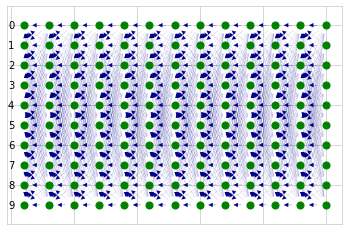

In [5]:
res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

In [6]:
def compute_flows(G, labels_to_index, input_nodes, length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()

    return flow_values



output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

(['0_0', '1_1', '2_2', '3_3', '4_4', '5_5', '6_6', '7_7', '8_8', '9_9'], [])